In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

In [168]:
images_dir = "C:/Users/User/mmp/6_semester/OIR/Обучение/"
file_list = os.listdir(images_dir)

# Попробуем OpenCV

In [3]:
cv_list = []
for x in file_list[:-4]:
    img = plt.imread(images_dir + x)
    cv_list.append(img)

## New try

In [5]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [6]:
def norm_img(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((9, 9), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 11)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [7]:
def choose_thresh(img):
    H = []
    for k in range(256):
        H.append(np.sum(img == k))
 
    def D1(p):
        S = np.dot(np.arange(p + 1), H[:p + 1])
        R = np.sum(H[:p + 1])
        if R == 0:
            return -1
        return S / R
 
    def D2(p):
        S = np.dot(np.arange(p + 1, 256), H[p + 1:])
        R = np.sum(H[p + 1:])
        if R == 0:
            return -1
        return S / R
 
    for p in range(255, 0, -1):
        thresh = D1(p) + D2(p) - 2 * p
        if thresh > 0:
            return p

In [8]:
def change_img(img, thresh):
    binary = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(binary, kernel, iterations = 1)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

    dilated_img = cv2.dilate(closing, np.ones((9, 9), np.uint8))

    kernel = np.ones((10, 10), np.uint8)
    erosion = cv2.erode(dilated_img, kernel, iterations = 2)

    return erosion

In [9]:
def find_medians(coords):
    (Cx, Cy) = (np.sum(coords, axis=0) / 3).astype(int)[0]
    x_0_1 = int((coords[0][0][0] + coords[1][0][0]) / 2)
    y_0_1 = int((coords[0][0][1] + coords[1][0][1]) / 2)
    x_0_2 = int((coords[0][0][0] + coords[2][0][0]) / 2)
    y_0_2 = int((coords[0][0][1] + coords[2][0][1]) / 2)
    x_2_1 = int((coords[2][0][0] + coords[1][0][0]) / 2)
    y_2_1 = int((coords[2][0][1] + coords[1][0][1]) / 2)
    arr = []
    arr.append(np.array([coords[0][0], [x_0_1, y_0_1], [Cx, Cy], [x_0_2, y_0_2]], dtype=np.int32))
    arr.append(np.array([coords[1][0], [x_0_1, y_0_1], [Cx, Cy], [x_2_1, y_2_1]], dtype=np.int32))
    arr.append(np.array([coords[2][0], [x_0_2, y_0_2], [Cx, Cy], [x_2_1, y_2_1]], dtype=np.int32))
    return arr, (Cx, Cy)

In [10]:
def check_green(img):
    hsv_min = np.array((53, 55, 147), np.uint8)
    hsv_max = np.array((83, 255, 255), np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    thresh = cv2.inRange(hsv, hsv_min, hsv_max)
    moments = cv2.moments(thresh, 1)
    if moments['m00'] > 0:
        return True
    else:
        return False

In [11]:
def check_blue(img):
    hsv_min = np.array((90, 50, 50), np.uint8)
    hsv_max = np.array((130, 255, 255), np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    thresh = cv2.inRange(hsv, hsv_min, hsv_max)
    moments = cv2.moments(thresh, 1)
    if moments['m00'] > 0:
        return True
    else:
        return False

In [12]:
def check_yellow(img):
    hsv_min = np.array((28, 100, 100), np.uint8)
    hsv_max = np.array((32, 255, 255), np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    thresh = cv2.inRange(hsv, hsv_min, hsv_max)
    moments = cv2.moments(thresh, 1)
    if moments['m00'] > 20: #maybe 20 or 2
        return True
    else:
        return False

In [13]:
def check_white(img):
    hsv_min = np.array((0, 0, 230), np.uint8)
    hsv_max = np.array((180, 25, 255), np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    thresh = cv2.inRange(hsv, hsv_min, hsv_max)
    moments = cv2.moments(thresh, 1)
    if moments['m00'] > 20: #maybe 30
        return True
    else:
        return False

In [14]:
def check_red(img):
    hsv_min = np.array((0, 200, 200), np.uint8)
    hsv_max = np.array((10, 255, 255), np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    thresh = cv2.inRange(hsv, hsv_min, hsv_max)
    moments = cv2.moments(thresh, 1)
    if moments['m00'] > 1:
        return True
    else:
        return False

In [15]:
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [49]:
def find_coords(img, new_img, output_file):
    original = img.copy()
    ROI_number = 0
    cnts = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    orig_stdout = sys.stdout
    f = open(output_file, 'w')
    sys.stdout = f
    eps = 0
    number = 0
    for c in cnts:
        [point_x, point_y, width, height] = cv2.boundingRect(c)
        approx = cv2.approxPolyDP(c, 0.07 * cv2.arcLength(c, True), True)

        if len(approx) == 3:
            dots = []
            arr, (Cx, Cy) = find_medians(approx)
            print('ROI_{}:'.format(number), (Cx, Cy))
            new_ROI = original[point_y : point_y + (height + eps), point_x : point_x + (width + eps)]
            cv2.imwrite('ROI_{}.png'.format(number), cv2.cvtColor(new_ROI, cv2.COLOR_RGB2BGR))

            for ar in arr:
                mask = np.zeros(img.shape, dtype=np.uint8)
                channel_count = img.shape[2]
                ignore_mask_color = (255,) * channel_count
                cv2.fillPoly(mask, [ar], ignore_mask_color)
                masked_image = cv2.bitwise_and(img, mask)
                ROI = masked_image[point_y : point_y + (height + eps), point_x : point_x + (width + eps)]
                ROI, a, b = automatic_brightness_and_contrast(ROI)
                if check_blue(ROI):
                    dots.append(4)
                elif check_green(ROI):
                    dots.append(2)
                elif check_red(ROI):
                    dots.append(5)
                elif check_white(ROI):
                    dots.append(1)
                elif check_yellow(ROI):
                    dots.append(3)
                else:
                    dots.append(0)
            print(dots)  
            number += 1

            cv2.drawContours(img, [c], 0, (0, 0, 255), 3)
            cv2.circle(img, (Cx, Cy), 10, (320, 159, 22), -1)

    cv2.imwrite('image_2.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(number)
    sys.stdout = orig_stdout
    f.close()
    return img

In [50]:
def process_image(img_name, output_file):
    img = plt.imread(img_name)
    r, g, b = cv2.split(img)
    thresh = choose_thresh(r)

    new_img = change_img(r, thresh)
    img = find_coords(img, new_img, output_file)
    cv2.imwrite('New_{}.png'.format(img_name), img)
    cv2.waitKey()
    return img

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

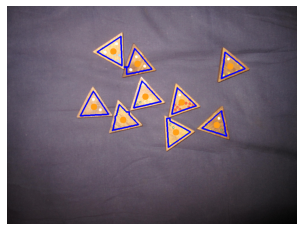

In [51]:
img = process_image('C:/Users/User/mmp/6_semester/OIR/Обучение/Pict_2_3.bmp', "Pict_2_3.txt")
image_show(img)